## Objective Function: Given a user, what is the probability that they will make a purchase in the next 7 days. 

You are NOT required to build/train a model. Your solution needs to have the following:

1. Read both the datasets and perform EDA (Exploratory Data Analysis).
2. Clean and preprocess the data.
3. Perform feature engineering and feature extraction.
        
      a. Based on conclusions from your EDA, create a set of features that can be used to solve the objective function.
      
      b. You are expected to be creative about extracting features - “quality is better than quantity”. You can go as high as 30-35 features (even more) but 10-12 well thought good quality features will give your submission a better score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB


import warnings
warnings.filterwarnings('ignore')

### 1.  Read both the datasets and perform EDA (Exploratory Data Analysis).

- Read in datasets, merged on Visitor ID
- Renamed the Conversion data set's timestamp to Conversion Time, and the Customer data set's timestamp to Last Seen
- Each row in both datasets has one Visitor ID per row, limiting concern for non-unique data
- However, there are some users who have multiple Session IDs - to revisit this at a later stage
- Dropped high cardinality columns Site ID and Site Name, in addition to ID
- A CONV feature was created as a binary indication of Conversion - this is to review behavior of various features during different states of conversion
- Using the Pandas Profiling EDA tool, we can see high correlation between segments and subsegments of the User Agent/Device information
- For each pair of matching features (ie BROWSER and BROWSER FAMILY), I've selected to keep the higher level of the two 
- After reviewing the basic summary statistics of each variable, I reviewed the conversion behavior between various categorical variable, both as a function of percentage and of total size
- In terms of stand out features, I found that users who had CONVERSION as their PAGE_VIEW_TYPE had a much higher rate of conversion (as stands to reason), but the total size of that group was minimal. 


In [2]:
##### Import data
cust = pd.read_parquet('customers.parquet')
conv = pd.read_parquet('conversions.parquet')

#### Clean pre-merge
conv.columns = ['CONVERSION_TIME', 'VISITOR_ID']
cust = cust.rename(columns={'REQUESTED_AT':'LAST_SEEN'})

## Review number of unique visitors per dataset
print(cust.VISITOR_ID.nunique())
print(len(cust))
print(conv.VISITOR_ID.nunique())
print(len(conv))

### Note: customer & conversion dataset has unique customer per row

24385
24385
1735
1735


In [3]:
## Merge datasets
df = cust.merge(conv, how='left', on=['VISITOR_ID']).reset_index(drop=True)

## Drop consistent columns (where there is a single value)
df.nunique()
df = df.drop(columns=['SITE_ID', 'SITE_NAME'])

## Given one row per user, drop ID cols (include one only)
df = df.drop(columns=['ID'])

## Note - session id has overlaps

## Create binary feature for conversion
df['CONV'] = df.CONVERSION_TIME
df.CONV = df.CONV.replace(np.nan, 0)
df.CONV = [1 if x!=0 else 0 for x in df.CONV]

# Review conversion percentage
df.CONV.value_counts(normalize=True)

0    0.92885
1    0.07115
Name: CONV, dtype: float64

In [4]:
#### Review overall EDA report
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
###### Drop highly correlated cols - keep lower unique cat values for ease
df = df.drop(columns = ['USER_AGENT', 'BROWSER', 'OS'])

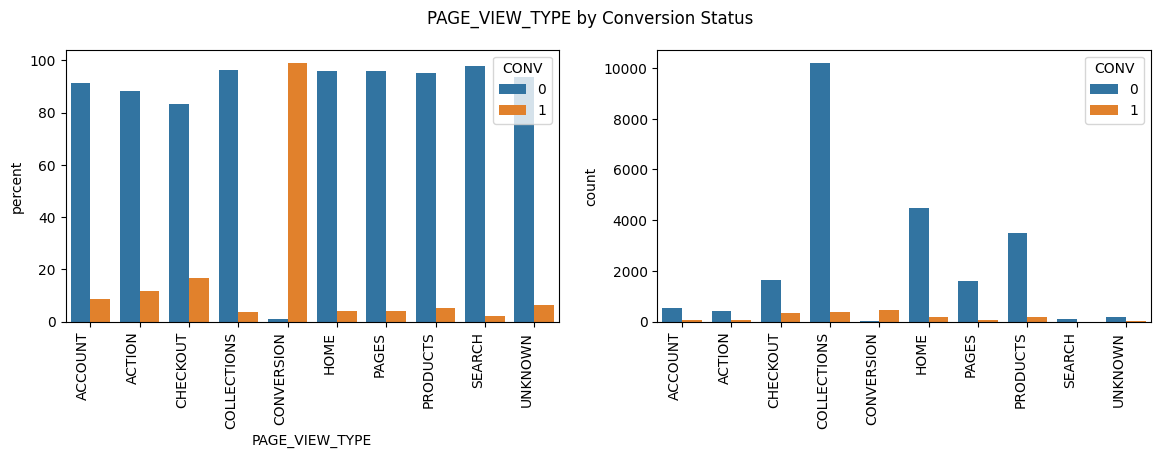

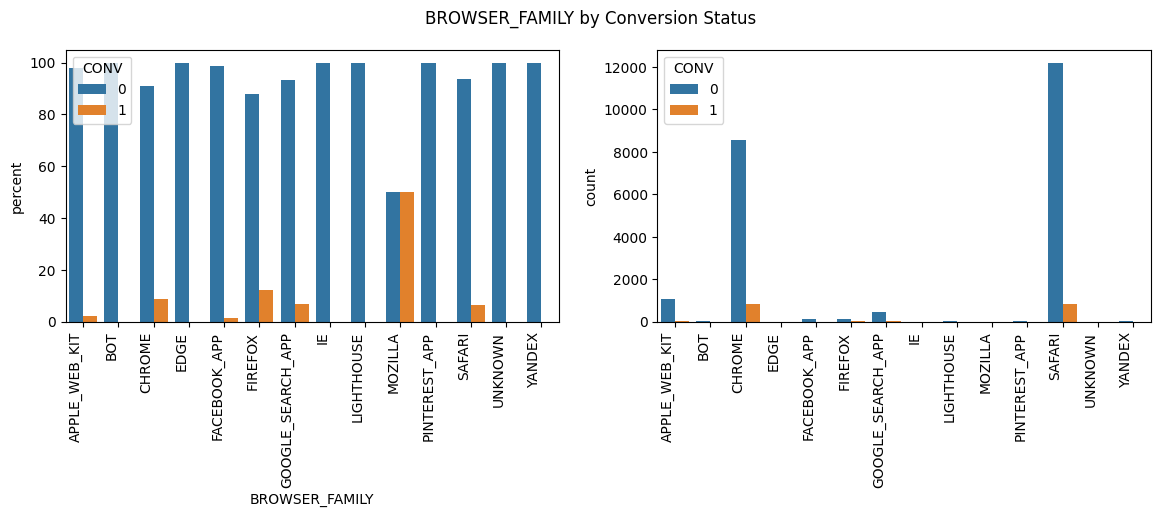

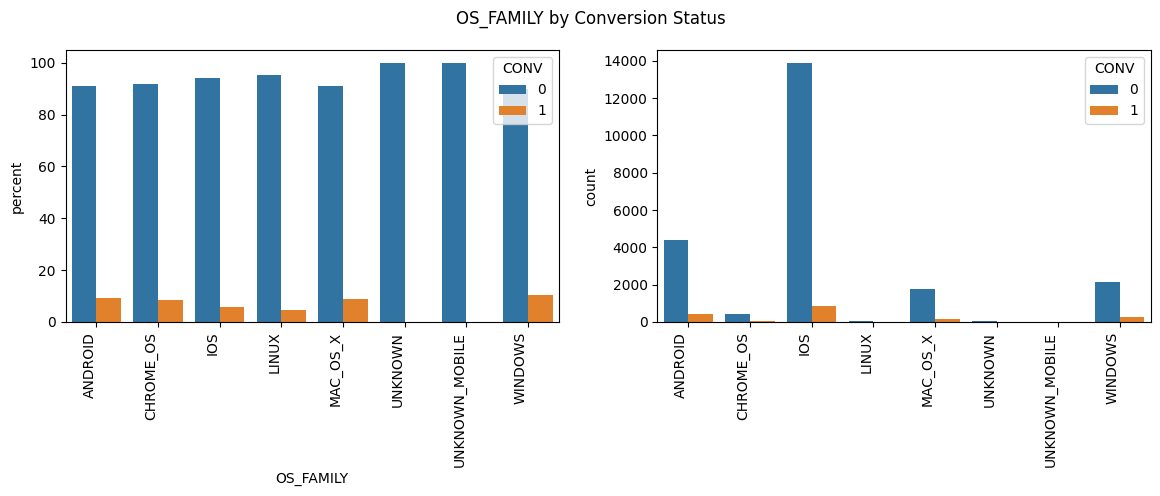

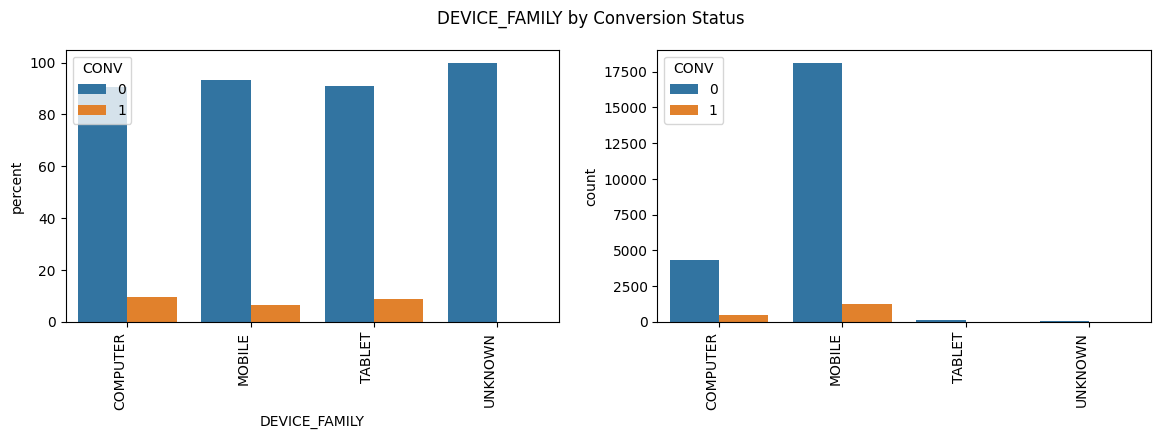

In [6]:
#### Review conversion percentage between various categorical variables
cat_vars = ['PAGE_VIEW_TYPE', 'BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY']

### Review both count and percentage by category
for cat in cat_vars:
    # Set plt
    plt.rcParams["figure.figsize"] = [14,4]
    fig, ax = plt.subplots(1,2)

    # Review proportion
    sns.barplot(x=cat, y='percent', hue='CONV', 
                data = (df
                        .groupby(cat)['CONV']
                        .value_counts(normalize=True)
                         .mul(100)
                        .rename('percent')
                        .reset_index()), ax=ax[0])
    plt.xlabel('')

    # Review count
    sns.barplot(x=cat, y='count', hue='CONV', 
                data = (df
                         .groupby([cat,'CONV'])
                         .VISITOR_ID
                         .count()
                         .reset_index(drop=False)
                         .rename(columns={'VISITOR_ID':'count'})), ax=ax[1])
    plt.xlabel('')
    fig.autofmt_xdate(rotation=90)
    fig.suptitle(f'{cat} by Conversion Status', fontsize=12)
    fig.show()

### 2. Clean & Preprocess the Data

#### Notes & Summary:
- After seeing a number of NA values in the dataset, I found that these were either due to a lack of conversion of a lack of FIRST SEEN value. As instructed in the assignment documentation, I revered those FIRST SEEN NA values to 1/10/22
- Various timestamps were cleaned to allow for datetime arithmetic
- Various binary summary flags were then created for ease in feature engineering process
    - PVS_BINARY: If a user has a valid page view summary
    - CVS_BINARY: If a user has a valid conversion summary


In [7]:
#### Review null values in dataset
df.isna().sum()

##### NULL values are explained in assignment description

#### Fill NA Firs t Seen with Jan 10, 2022
df.FIRST_SEEN = df.FIRST_SEEN.fillna('"2022-01-10"')

# Clean timestamps; replace timezone
df.FIRST_SEEN = [x.replace('"', '') for x in df.FIRST_SEEN]
df.FIRST_SEEN = [pd.to_datetime(x).replace(tzinfo=None) for x in df.FIRST_SEEN]
df.LAST_SEEN = [pd.to_datetime(x).replace(tzinfo=None) for x in df.LAST_SEEN]
df.CONVERSION_TIME = [pd.to_datetime(x).replace(tzinfo=None) for x in df.CONVERSION_TIME]

# Create flags for summaries
df.CONVERSION_SUMMARIES = ['[]' if x==None else x for x in df.CONVERSION_SUMMARIES]
df['PVS_BINARY'] = [1 if x!=None else 0 for x in df.PAGE_VIEW_SUMMARIES]
df['CVS_BINARY'] = [1 if x!='[]' else 0 for x in df.CONVERSION_SUMMARIES]

### 3. Perform feature engineering and feature extraction.
- My focus in this phase was to pull apart the conversion and page view summaries to try and create a fuller picture of each user's website journey
- For each user,
    - A ‘final’ timestamp was created to indicate either their last seen or their conversion time if they had converted
    - If there was a valid page view summary,
        - The ‘last seen’ page view and dependent information were added into their page view summary
        - The summary was filtered to within 7 days of their ‘final’ timestamp
        - An aggregate feature was created for each unique page view type and the times it was visited
        - An aggregate feature was created for each unique product category type and the times it was visited
        - A full page view journey was created as a single string value - this is for use at a later stage potentially pulling in Markov or other multitouch attribution modeling
    - If there was a valid conversion summary,
        - A feature was created to denote the time between their last conversion and their final timestamp
        - A feature was created to denote the number of previous conversions
        - A feature was created to denote the amount previously spent
- For each of the newly created variables, I plotted their relationship with conversion for further analysis

In [8]:
###### Extract path features per user
path_data = []

for idx in list(df.VISITOR_ID.unique()):
    user_dct = {}
    user_dct.update({'VISITOR_ID':idx})

    # Get visitor data
    vi_data = df[df.VISITOR_ID==idx].reset_index(drop=True)

    # Set final timestamp
    ### If conv, timestamp = conv time
    ### If not conv, timestamp = last seen
    fin_ts = vi_data.CONVERSION_TIME[0] if vi_data.CONV[0]==1 else vi_data.LAST_SEEN[0]
    user_dct.update({'fin_ts':fin_ts})

    # Get flags
    pvs_flag = vi_data.PVS_BINARY[0]
    cvs_flag = vi_data.CVS_BINARY[0]
    conv_flag = vi_data.CONV[0]

    # Separate last page view
    lpv = vi_data[['PAGE_ID', 'PAGE_VIEW_TYPE', 'LAST_SEEN']]
    lpv.columns = ['page_id', 'page_view_type', 'requested_at']
    lpv['product_category_type'] = np.nan

    ###### Page view summaries
    if pvs_flag==1:
        pvs = vi_data.PAGE_VIEW_SUMMARIES.reset_index(drop=True)[0]
        pvs = json.loads(pvs)

        # Filter page views by timestamp
        pvs_df = pd.DataFrame.from_dict(pvs).sort_values(by='requested_at').reset_index(drop=True)
        pvs_df.requested_at = [pd.to_datetime(x).replace(tzinfo=None) for x in pvs_df.requested_at]
        # Get last 7 days of data
        min_review_ts = fin_ts - timedelta(days=7)
        pvs_df = pvs_df[pvs_df.requested_at>=min_review_ts].reset_index(drop=True)

        # Add in last page view 
        pvs_df = pd.concat([pvs_df, lpv]).sort_values(by='requested_at').reset_index(drop=True)

    else:
        pvs_df = lpv.copy()

    # Count by page_view_type
    pageview_type_counts = pvs_df.page_view_type.value_counts().to_dict()
    for pv, count in pageview_type_counts.items():
        new_key = f'pv_{pv}'
        user_dct.update({new_key:count})

    # Count by product_category_type
    prod_cat_type_counts  = pvs_df.product_category_type.value_counts().to_dict()
    for pc, count in prod_cat_type_counts.items():
        new_key = f'pvcat_{pc}'
        user_dct.update({new_key:count})

    # Create page view journey
    journey = '>'.join(list(pvs_df.page_view_type))
    user_dct.update({'journey':journey})

    
    ##### Conversion summaries
    if cvs_flag==1:
        # Review page view and conversion summaries
        cvs = vi_data.CONVERSION_SUMMARIES.reset_index(drop=True)[0]
        cvs = json.loads(cvs)
        cvs_df = pd.DataFrame.from_dict(cvs).sort_values(by='requested_at').reset_index(drop=True)
        # Find time between last conversion; num conversions
        time_between_last_conv = (fin_ts - pd.to_datetime(cvs_df.requested_at.max()).replace(tzinfo=None)).days
        user_dct.update({'time_between_last_conv':time_between_last_conv})
        num_prev_conv = cvs_df.requested_at.nunique()
        user_dct.update({'num_prev_conv':num_prev_conv})
        # Find total amount spent
        amount_spend = cvs_df.conversion_value.sum()
        user_dct.update({'amount_spend':amount_spend})
    else:
        pass
    
    path_data.append(user_dct)

In [9]:
### Reset dataframe, merge with original set
pd_df = pd.DataFrame.from_dict(path_data)
pd_df = pd_df.fillna(0)
pd_df = pd_df[list(sorted(pd_df.columns))]
df2 = df.merge(pd_df, how='left', on=['VISITOR_ID'])

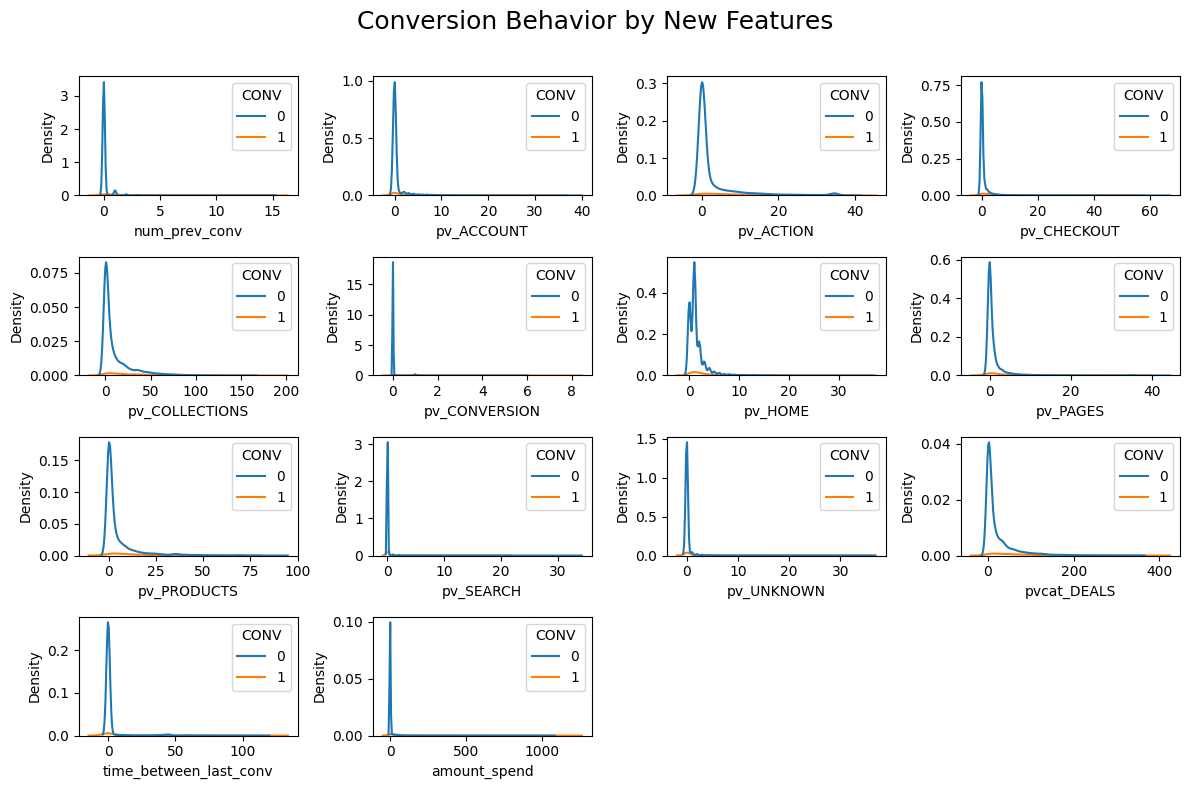

In [10]:
### Review new features' relationship with conversion
revs = ['num_prev_conv', 'pv_ACCOUNT',
       'pv_ACTION', 'pv_CHECKOUT', 'pv_COLLECTIONS', 'pv_CONVERSION',
       'pv_HOME', 'pv_PAGES', 'pv_PRODUCTS', 'pv_SEARCH', 'pv_UNKNOWN',
       'pvcat_DEALS', 'time_between_last_conv', 'amount_spend']

fig = plt.figure(figsize=(12,8))
for ix, ree in enumerate(revs):
    plt.subplot(4,4,ix+1)
    sns.kdeplot(data=df2, x=ree, hue="CONV")
    
fig.suptitle(f'Conversion Behavior by New Features\n', fontsize=18)
fig.tight_layout()
plt.show()    

**Segmentation**
- I proceeded to test out segmentation and clustering techniques. While this may not feed directly into a future model, it allows understanding of how various user clusters behave 
- Of the three clusters found from K-Mean Clustering, the conversion percentage increases drastically, however the sizes of those clusters are inversely related
- This stands to reason as the overall percentage of users who converted is ~7%
- In reviewing the cluster behavior by the new features created,
    - Number of previous conversions, time between last conversion, total amount spent, and a number of pages with higher views move similarly to the pattern of conversion behavior between the three clusters

In [11]:
####### Segmentation
# Get dummy device information variables
dev_vars = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY']
dev_df = df2[dev_vars]
df2 = pd.get_dummies(df2, columns=dev_vars)
df2 = pd.concat([df2, dev_df],axis=1)

# Get new dev var names
dev_vars2 = [[x for x in df2.columns if x.startswith(y)] for y in dev_vars]
dev_vars2 = [y for x in dev_vars2 for y in x] 
dev_vars2 = [x for x in dev_vars2 if x not in dev_vars]

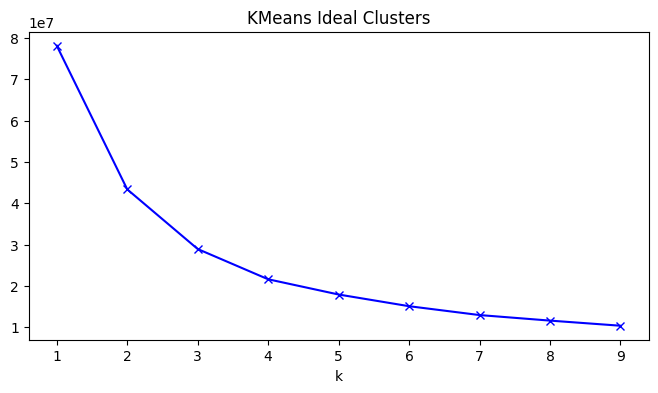

In [12]:
###### KMeans Clustering
# Find elbow value for 'ideal' grouping
inert = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df2[revs+dev_vars2])
    inert.append(kmeanModel.inertia_)
    
plt.figure(figsize=(8,4))
plt.plot(K, inert, 'bx-')
plt.xlabel('k')
plt.title('KMeans Ideal Clusters')
plt.show()

### Use 3

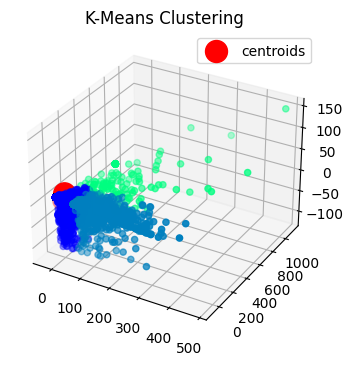

In [13]:
#### Using clusters, use PCA to plot
km = KMeans(n_clusters=3)
km.fit(df2[revs+dev_vars2])
labels = km.predict(df2[revs+dev_vars2])

pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(df2[revs+dev_vars2]), columns = ['comp1', 'comp2', 'comp3'])
pca_df['labels'] = labels

# Plot
clusts = pca_df.labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(km.cluster_centers_[:, 3],
            km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 2],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
ax.scatter(pca_df.comp1, pca_df.comp2, pca_df.comp3,
                     c=clusts,s=20, cmap='winter')

ax.set_title('K-Means Clustering')
ax.legend()
plt.show()

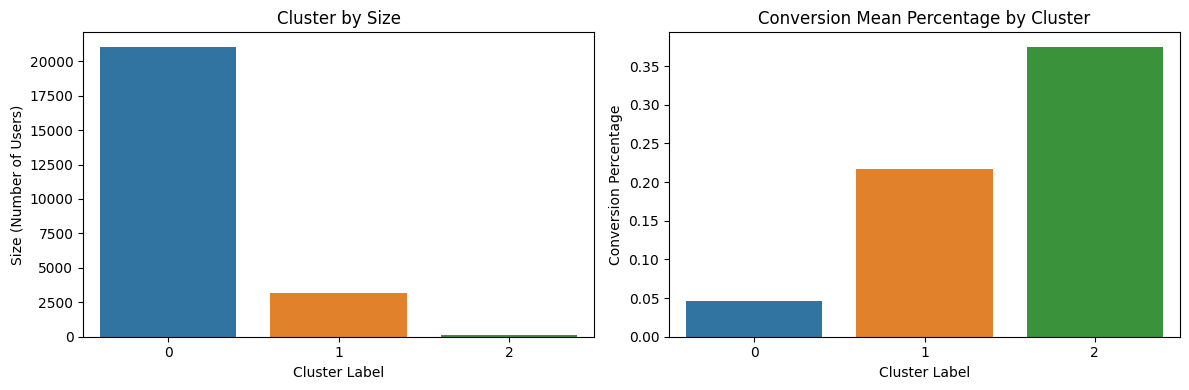

In [14]:
# Review connections between clusters and conversion values
df2['cluster_label'] = labels

# Review size of clusters
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='cluster_label', y='CONV', data = df2.groupby('cluster_label')['CONV'].size().reset_index(drop=False))
plt.title('Cluster by Size')
plt.ylabel('Size (Number of Users)')
plt.xlabel('Cluster Label')

# Plot conversion proportion by cluster
plt.subplot(1,2,2)
sns.barplot(x='cluster_label', y='CONV', data = df2.groupby('cluster_label')['CONV'].mean().reset_index(drop=False))
plt.title('Conversion Mean Percentage by Cluster')
plt.ylabel('Conversion Percentage')
plt.xlabel('Cluster Label')
fig.tight_layout()
plt.show()


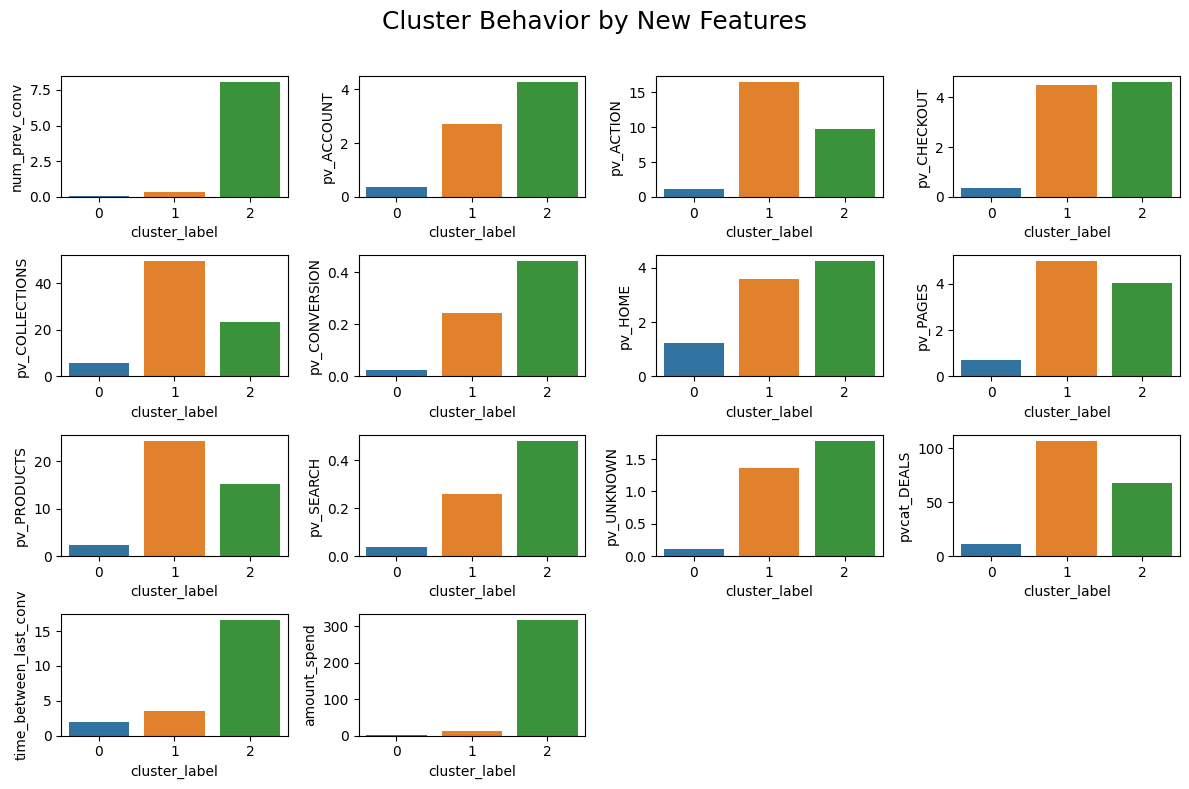

In [15]:
## Review cluster behavior by new features
fig = plt.figure(figsize=(12,8))

for ix, var in enumerate(revs):
    plt.subplot(4,4,ix+1)
    sns.barplot(x='cluster_label', y=var, data = df2.groupby('cluster_label')[var].mean().reset_index(drop=False))
fig.suptitle(f'Cluster Behavior by New Features\n', fontsize=18)
fig.tight_layout()
plt.show()

#### Modeling
- As a very simple modeling exercise, I used the new features created to try and predict the binary CONV variable
- In doing so, I used two probabilistic models and two tree-based models
- An interesting finding was that incorporating the dummy-encoded device variables showed varied results than the model omitting those variables - this would be something to look into
- I chose Recall as a primary evaluation technique due to the importance of properly predicting a 1 
- Clusters - not incorporated in model but useful for analysis between segments

In [16]:
####### Binary classification models
### Both tree-based and probability based

#### With dummy device information
X,y = df2[revs+dev_vars2], df2['CONV']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    # Eval
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    # Append
    outputs.append([model, acc, f1, recall])
    

# Review
pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall'])

,model,accuracy,f1,recall
0,LogisticRegression(),0.939612,0.446469,0.340870
1,GaussianNB(),0.126367,0.139518,0.991304
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.959990,0.633257,0.483478
3,(DecisionTreeClassifier(random_state=142553623...,0.960611,0.658037,0.530435


In [17]:
#### Without dummy device information
X,y = df2[revs], df2['CONV']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    # Eval
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    # Append
    outputs.append([model, acc, f1, recall])
    

# Review
pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall'])

,model,accuracy,f1,recall
0,LogisticRegression(),0.936754,0.427447,0.314570
1,GaussianNB(),0.903703,0.507311,0.660596
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.960611,0.663839,0.518212
3,(DecisionTreeClassifier(random_state=164626197...,0.960239,0.669421,0.536424


## Summary
- The following features were created to help address the objective function: 
    - CONV : Binary feature as to whether the user did or did not convert
    - PVS_BINARY: Binary feature as to whether the user has a valid page view summary
    - CVS_BINARY: Binary feature as to whether the user has a valid conversion summary
    - amount_spend: Continuous feature denoting total amount user has spent prior
    - fin_ts: Timestamp of either the conversion time if the user converted, or their last seen time if the user had not converted
    - journey: String series of page view journey in the 7 days leading up to final timestamp
    - num_prev_conv: Continuous feature of number of previous conversions
    - pv_ACCOUNT: Continuous feature - count of ACCOUNT page in user’s page view journey
    - pv_ACTION: Continuous feature - count of ACTION page in user’s page view journey
    - pv_CHECKOUT: Continuous feature - count of CHECKOUT page in user’s page view journey
    - pv_COLLECTIONS: Continuous feature - count of COLLECTIONS page in user’s page view journey
    - pv_CONVERSION: Continuous feature - count of CONVERSION page in user’s page view journey
    - pv_HOME: Continuous feature - count of HOME page in user’s page view journey
    - pv_PAGES: Continuous feature - count of PAGES page in user’s page view journey
    - pv_PRODUCTS: Continuous feature - count of PRODUCTS page in user’s page view journey
    - pv_SEARCH: Continuous feature - count of SEARCH page in user’s page view journey
    - pv_UNKNOWN: Continuous feature - count of UNKNOWN page in user’s page view journey
    - pvcat_DEALS: Continuous feature - count of DEALS page category in user’s page view journey
    - time_between_last_conv: Continuous feature - time between their prior conversion and their final timestamp 
    - cluster_label: Categorical feature - cluster label based on Means clustering
- Additionally, dummy encoded variables were created for BROWSER_FAMILY, OS_FAMILY, and DEVICE_FAMILY


### Next Steps
- For next steps, I think the initial modeling work has a long way to go 
- Additionally, it would be interesting to use the page view summaries in a LSTM network 
- I'd like to look further into users with multiple sessions in the dataset
- While cutting the page view summaries down to 7 days made some amount of sense, I do think it necessary to go through that section in more detail and review a more relational understanding between pages, and review users' previous journeys leading up to previous conversions
- As mentioned above, an attribution model using the user journeys could be beneficial to understand the impact each page has on conversion
- My main focus throughout has been on the page view summary and how a user's journey impacts their conversion status - it would be beneficial to also step away from that angle and try and dig into a different aspect of the dataset as well


